In [1]:
import pandas as pd
import numpy as np
import re
import pickle
import seaborn as sb

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer  
from nltk import pos_tag
import nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt

In [2]:
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\marva\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\marva\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\marva\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
df = pd.read_csv("winemag-data-130k-v2.csv")
df['title'] = (df['title'].str.replace('  ', ' ', regex=False).str.replace(r'\s\(.*(\(.*\))?\)', '', regex=True).str.strip())  
# df.head()

In [ ]:
lens = [len(x) for x in df['description']]
plt.hist(lens, bins=100)
plt.show()

In [5]:
# df['variety'].value_counts()

Kako u skupu postoji 707 vrsti grozda, želimo da ih grupišemo u 9 kategorija, kao u https://winefolly.com/tips/the-9-major-wine-styles/.

Za to je koriscen gpt i rezultati su upisani u `wine_variety_style.csv`. Za vina koja su obeležena kao mešavina vrsta nije bilo moguce odrediti kategoriju na ovaj nacin, zbog cega je za njih tražena kategorija po imenu, i upisana u `wine_title_style.csv`. Bilo je potrebno ispitati 700 vrsti grozda i 10k pojedinacnih vina, cime smo dobili informafcije o kategoriji za 130k vina.

In [6]:
wine_variety_style = pd.read_csv('wine_variety_style.csv')
wine_title_style = pd.read_csv('wine_title_style.csv')
# print(wine_variety_style['style'].value_counts())

In [7]:
df_merged = pd.merge(df, wine_variety_style, how='left', left_on='variety', right_on='variety')
df_merged = pd.merge(df_merged, wine_title_style, how='left', left_on='title', right_on='wine_name')
df_merged['style'] = df_merged['style_x'].fillna(df_merged['style_y'])
# df_merged.info()

In [8]:
# df_merged[df_merged['country'] == 'Serbia'][['title','variety','style']]

In [9]:
df = df_merged[['country','description','points','price','title','variety','style']].dropna(subset=['style'])
# df.info()

In [10]:
df['style'].value_counts()

style
Full-Bodied Red Wines          47883
Aromatic White Wines           17556
Medium-Bodied Red Wines        15920
Light-Bodied Red Wines         14971
Full-Bodied White Wines        14572
Light-Bodied White Wines        9630
Champagne & Sparkling Wines     4604
Rosé Wines                      3785
Dessert & Fortified Wines       1098
Name: count, dtype: int64

In [11]:
X = df['description']  
y = df['style']
print(X[1])
print(y[1])

This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's  already drinkable, although it will certainly be better from 2016.
Full-Bodied Red Wines


Recenzije vina su kratke i detaljne i opisuju njehov ukus, miris i teksturu. Konstrukcije rečenica su jednostavne i ne zavise mnogo od redosleda reči, što nam govori da je dovoljno da posmatramo samo pojedinačne reči koje se u komentaru nalaze. 

Na primeru vidimo opis koji sadrži reči "ripe", "smooth", "tannin", "berry", što bi moglo da nas asocira na jako crno vino, i teško bi se našle u opisu penušavog vina.

U opisu najbitnije su nam imenice i pridevi, zbog čega ćemo ukloniti sve ostale vrste reči. 

In [12]:
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer() 
stemmer = PorterStemmer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z]+", " ", text)
    
    pos_tagged = pos_tag(text.split())
    
    text = [word for word, tag in pos_tagged
        if tag[0] in {'J', 'N'} and word not in stop_words]
    
    text = [lemmatizer.lemmatize(word) for word in text]
    
    return " ".join(text)

In [13]:
clean_text(X[1])

'ripe fruity wine firm tannin juicy red berry fruit acidity drinkable better'

In [14]:
# X = X.apply(clean_text)
# with open("x_clean.pkl", "wb") as file:
#     pickle.dump(X, file)
with open("x_clean.pkl", "rb") as file:
    X = pickle.load(file)

In [15]:
X.head()

0    aroma tropical fruit broom brimstone herb pala...
1    ripe fruity wine firm tannin juicy red berry f...
2    tart snappy flavor lime flesh green pineapple ...
3    pineapple rind lemon pith orange blossom aroma...
4    much regular bottling rough tannic rustic eart...
Name: description, dtype: object

Za ovo "čišćenje teksta" nismo koristili nikakvo znanje koje je specifično za konkretan skup podataka. Za dalju obradu potrebno je da izdvojimo skup za testiranje kako ne bi uticao na odluke koje pravimo.

Za početak ćemo izdvojiti podatke samo na skup za obučavanje i za testiranje, dok ćemo skup za validaciju izdvojiti iz skupa za obučavanje kasnije i koristiti za testiranje samog modela.  

Za krajnje testiranje izdvajamo 20% svih podataka.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Za vektorizaciju teksta koristimo TF-IDF. IDF deo je jasno da nam je bitan jer želimo reči koje se spominju u više recenzija, dok je TF upitan za ovaj problem. Kako su komentari kratki, reči će se uglavnom pojavljivati najviše jednom, i sve reči jednog komentara imaće isti TF? To nam u sustini ne smeta?

Zanimaju nas reči koji se nalaze u barem 0.1% dokumenata (~100), kako bismo odstranili greške u kucanju i retke izraze, ali ne više od 99% jer nam te reči verovatno ne nose nikakvu informaciju (kao naprimer reč "wine"). 

In [17]:
tfidf_vectorizer = TfidfVectorizer(min_df=0.001, max_df=0.9) 

tfidf_train_vectors = tfidf_vectorizer.fit_transform(X_train)
tfidf_test_vectors = tfidf_vectorizer.transform(X_test)

print(len(tfidf_vectorizer.get_feature_names_out()))
print(tfidf_vectorizer.get_feature_names_out())

1587
['abrasive' 'abundance' 'abundant' ... 'zinfandel' 'zingy' 'zippy']


Na ovako pripremljenim podacima primenićemo prvo Naivni Bajesov model. Potrebno je da sada iz skupa podataka za obučavanje izdvojimo skup za validaciju.

In [18]:
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(tfidf_train_vectors, y_train, test_size=0.2, random_state=42,stratify=y_train)

In [19]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_train, y_train_train)
y_pred = nb_classifier.predict(X_train_val)

In [20]:
y_train_train

692          Full-Bodied Red Wines
122759       Full-Bodied Red Wines
116888      Light-Bodied Red Wines
35809      Full-Bodied White Wines
102631    Light-Bodied White Wines
                    ...           
105921    Light-Bodied White Wines
129921     Medium-Bodied Red Wines
122188       Full-Bodied Red Wines
87481        Full-Bodied Red Wines
109813       Full-Bodied Red Wines
Name: style, Length: 83212, dtype: object

In [21]:
wine_style_order = [
    "Champagne & Sparkling Wines", "Aromatic White Wines",
    "Light-Bodied White Wines", "Full-Bodied White Wines", "Rosé Wines",
    "Light-Bodied Red Wines", "Medium-Bodied Red Wines", "Full-Bodied Red Wines", "Dessert & Fortified Wines"
]
class_report = classification_report(y_train_val, y_pred, labels=wine_style_order)
print("\nClassification Report:\n", class_report)


Classification Report:
                              precision    recall  f1-score   support

Champagne & Sparkling Wines       0.79      0.48      0.59       736
       Aromatic White Wines       0.61      0.78      0.68      2809
   Light-Bodied White Wines       0.62      0.40      0.49      1541
    Full-Bodied White Wines       0.69      0.68      0.69      2332
                 Rosé Wines       0.76      0.46      0.57       606
     Light-Bodied Red Wines       0.82      0.47      0.60      2395
    Medium-Bodied Red Wines       0.57      0.17      0.27      2547
      Full-Bodied Red Wines       0.66      0.95      0.78      7661
  Dessert & Fortified Wines       0.87      0.07      0.14       176

                   accuracy                           0.67     20803
                  macro avg       0.71      0.50      0.53     20803
               weighted avg       0.67      0.67      0.63     20803



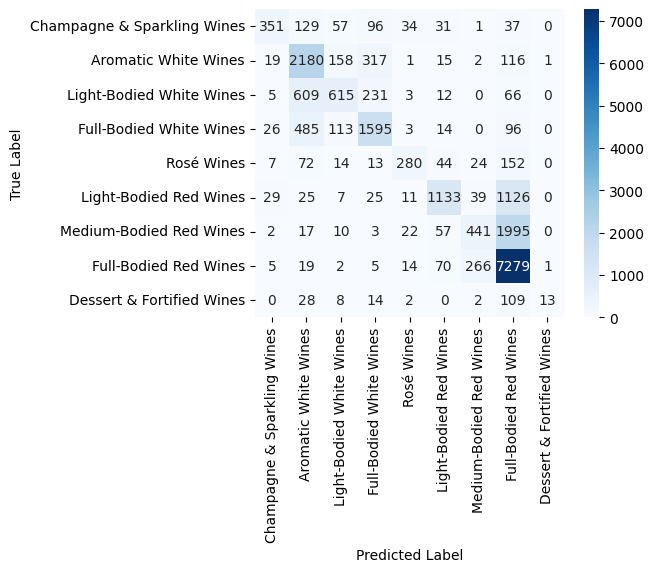

In [22]:
conf_matrix = confusion_matrix(y_train_val, y_pred, labels=wine_style_order)

plt.figure(figsize=(5, 4))
sb.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=wine_style_order, yticklabels=wine_style_order)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=90)  
plt.show()

Klase nisu balansirane u smislu njihove prisutnosti u skupu podataka, ali jesu sve jednake važnosti, zbog čega nemamo potrebu za OverSampling. 

Iz Bajesove formule koja se koristi za ovaj model,  $P(S_k | r) = \frac{P(S_k) \cdot P(r | S_k)}{P(r)}$, vidimo da će vino sa recenzijom $r$ koje ima jednake verovatnoće $P(r | S_i)$ i $P(r | S_j)$ za dva različita stila $i$ i $j$ biti izabran onaj stil koji je inače više prisutan. 

Ovim se može objasniti zašto su desertna vina često zamenjena za jaka crna vina, što vidimo u matrici konfuzije.

Pored toga što ih ima malo, desertna vina imaju veći diverzitet. Mogu biti crna, bela, jača i slabija, što ih čini znazno težim za klasifikovanje. 

Iz matrice konfuzije vidimo da model češće zameni jako crno vino sa laganim crnim vinom, nego što ga zameni sa nekim belim. Mi znamo da je to manja greška, zbog čega treba da promenimo metriku.

In [23]:
feature_names = tfidf_vectorizer.get_feature_names_out()

log_probabilities = nb_classifier.feature_log_prob_
log_prob_df = pd.DataFrame(log_probabilities, columns=feature_names, index=nb_classifier.classes_)
for category in nb_classifier.classes_:
    print(f"\nTop words for '{category}':")
    top_words = log_prob_df.loc[category].sort_values(ascending=False).head(10)
    print(top_words)


Top words for 'Aromatic White Wines':
wine      -4.241582
flavor    -4.339272
acidity   -4.474984
lemon     -4.532657
citrus    -4.534460
fruit     -4.574917
apple     -4.577660
finish    -4.605266
palate    -4.643791
peach     -4.653273
Name: Aromatic White Wines, dtype: float64

Top words for 'Champagne & Sparkling Wines':
apple     -4.149482
wine      -4.425838
acidity   -4.487774
crisp     -4.584883
fruit     -4.624348
flavor    -4.648640
dry       -4.673843
citrus    -4.682687
fresh     -4.743230
white     -4.787624
Name: Champagne & Sparkling Wines, dtype: float64

Top words for 'Dessert & Fortified Wines':
wine        -4.248724
sweet       -4.510423
port        -4.542771
acidity     -4.558481
fruit       -4.566192
flavor      -4.852568
rich        -4.863157
character   -4.930032
wood        -5.015548
ripe        -5.045565
Name: Dessert & Fortified Wines, dtype: float64

Top words for 'Full-Bodied Red Wines':
wine         -4.213550
black        -4.283388
tannin       -4.308379
f